# 5. Реальные данные

### Подключение необходимых библиотек

In [26]:
import numpy as np
import pandas as pd
import statistics as sts
import scipy.stats as stats
import matplotlib.pyplot as plt
import csv
import math

In [27]:
# Список всех рассматриваемых годов
years = ['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
# Список названий всех используемых тикеров
tickers = ['AAPL','ADBE','CSCO','FB','GOOGL','INTC','MSFT','NFLX','NVDA']

### Функция для оценки параметров $\mu$ и $\sigma$ получаемой выборки 

In [28]:
def param_estimation(sample):
    # Сортируем по возрастанию полученную выборку 
    sample.sort()
    # Объём выборки
    length = len(sample)
    # Считаем количество интервалов, на которые мы разобьём выборку
    log = math.log2(len(sample))
    k = int(1 + log)
    # Создаём список для центральных точек для каждого полученного интервала
    cpoint = [min(sample)]
    # Определяем шаг для прохождению по выборке
    step = (max(sample) - min(sample))/k
    
    # Создаём список для данных для каждого полученного интервала
    segment_list = []
    # Заполняем созданный список
    segment_list.append([part for part in sample if part < step/2 + cpoint[-1]])
    for i in range(1, k):
        cpoint.append(cpoint[0] + step * (i-1))
        segment_list.append([x for x in sample if cpoint[-1] - step/2 < x < cpoint[-1] + step/2])
    cpoint.append(cpoint[0] + step * (k - 1))    
    segment_list.append([part for part in sample if part > cpoint[-1] - step/2])
    
    # Получаем список частот (кол-ва элементов в каждом интервале)
    freq = [len(part) for part in segment_list]
    
    # Считаем значение мат.ожидания в 1-м приближении (по формуле из теор.справки)
    loc = 0
    for value in range(len(freq)):
        loc += freq[value] * cpoint[value]
    loc = loc/length
    
    # Считаем значение ст.отклонения в 1-м приближении (по формуле из теор.справки)
    scale = 0
    for value in range(len(freq)):
        scale += freq[value] * (cpoint[value] - loc)**2
    scale = (scale/length)**(1/2)
    
    # Вывод мат.ожидания, ст.отклонения, списка частот и списка центр.точек
    return loc, scale, freq, cpoint

### Функция для вычисления статистики критерия χ² Пирсона

In [29]:
def ChiSquare(sample):
    n_days = len(sample)
    # Считаем количество интервалов, на которые мы разобьём выборку
    log = math.log2(len(sample))
    k = int(1 + log)
    # Определяем шаг для прохождению по выборке
    step = (max(sample) - min(sample))/k
    # Получаем необходимые характеристики 
    mu, sigma, frequency, cpoint = param_estimation(sample)
    # Создаём распределение для сравнения его со случайной выборкой 
    expected = stats.norm(mu, sigma)
    
    # Создаём список вероятностей попадания значений в полученные интервалы
    p_list = []
    # Заполняем созданный список
    p_list.append(expected.cdf(cpoint[0] + step/2))
    for value in range(1, len(cpoint)-1):
        p_list.append((expected.cdf(cpoint[value] + step/2)-expected.cdf(cpoint[value] - step/2)))
    p_list.append(1-expected.cdf(cpoint[-1] - step/2))

    # Получения статистики χ²
    chi_sqare_stat = 0
    # Создаём список для заполнения i-ми статистиками
    statistics_list = []
    for i in range(len(p_list)):
        statistics_list.append(((frequency[i] - n_days * p_list[i])**2) / (n_days * p_list[i]))
        chi_sqare_stat += statistics_list[i]
    # Получения p-values χ²
    #chi_sqare_pvalue = (stats.chi2(len(frequency)-3).sf(chi_sqare_stat))
    
    # Вывод статистики и P-значения критерия χ²
    #return chi_sqare_stat, chi_sqare_pvalue
    return chi_sqare_stat

### Функция для вычисления P-значений критерия χ² Пирсона  и 

In [30]:
def p_value_search(sample):
    sample.sort()
    value_0 = ChiSquare(sample)
    counter = 0
    for value in range(len(sample)):
        if sample[value] > value_0: 
            counter = counter + 1
    p_value = counter/len(sample)
    return np.round(p_value,4)

### Функция для считывания и обработки csv-файлов с данными тикеров

In [31]:
def analysis(ticker, year):
    # Считываем csv-файл с данными тикера
    ticker_data = pd.read_csv(ticker + '.csv', sep = ',')

    # Форматируем файл, удаляем лишние столбцы
    cols = ['Close','Low','Adj Close','Volume']
    ticker_info = ticker_data.drop(cols,axis=1)
    #for i in range()

    # Форматируем файл, "срезаем" дату до значения года
    year_list = [(str(ticker_info['Date'][i])[:4]) for i in range(len(ticker_info['Date'])) ]
    ticker_info['Date'] = year_list

    # Удаляем строки с данные за отпавшие в результате анализа годы
    ticker_info = ticker_info.drop(ticker_info[ticker_info.Date == '2012'].index)
    ticker_info = ticker_info.reset_index(drop=True)

    # Пустой список P-значений
    p_values_list = []

    # Функция поиска P-значений для выборок, заполненных ежедневными разностями между ценой открытия и максимумом
    for year in years:
        diff_list = []
        # Создаем список индексов торговых дней за конкретный год
        trade_index_list = list(np.where(ticker_info['Date'] == year)[0])[:-1]
        diff_list = [(ticker_info['High'][day]-ticker_info['Open'][day])*100 for day in trade_index_list]
        p_values_list.append(p_value_search(diff_list))

    return(p_values_list)

### Формирование DataFrame'ов из P-значений

In [32]:
# Создаём пустой DataFrame
p_value_data = pd.DataFrame()
p_value_list_copy = []
# Пустой список для построения гистограммы P-значений
p_value_hist = []

# Заполняем DataFrame значениями по каждому тикеру
for ticker in tickers:
    t = analysis(ticker,years)
    for value in range(len(t)):
        p_value_list_copy.append(t[value])
        p_value_hist.append(int(t[value]*10))
    t = pd.DataFrame(t).transpose()
    p_value_data = p_value_data.append(t)
    
p_value_list_copy = np.split(np.array(p_value_list_copy), len(tickers))
# Изменяем названия строк и столбцов
p_value_data.columns = years
p_value_data.index = tickers

In [33]:
# p_value_data - Вывод таблицы P-значений для реальных данных

### Сохраним данные в csv-файле

In [34]:
p_value_data.to_csv('Таблица 8. P-значения для реальных данных.csv', sep = ';')

### Вывод гистограммы P-значений 

([<matplotlib.axis.XTick at 0x20335f0c5b0>,
 [Text(0, 0, '0.0'),
  Text(1, 0, '0.1'),
  Text(2, 0, '0.2'),
  Text(3, 0, '0.3'),
  Text(4, 0, '0.4'),
  Text(5, 0, '0.5'),
  Text(6, 0, '0.6'),
  Text(7, 0, '0.7'),
  Text(8, 0, '0.8'),
  Text(9, 0, '0.9'),
  Text(10, 0, '1.0')])

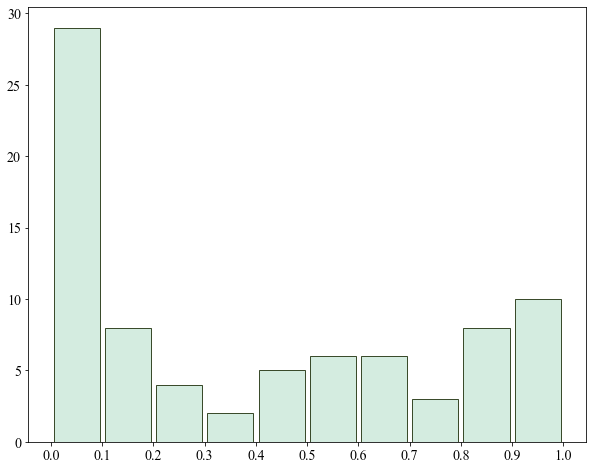

In [35]:
font = {'family': 'serif', 'serif': 'Times New Roman', 'weight': 'normal','size':14}
plt.rc('font',**font)

fig,ax = plt.subplots(figsize=(10, 8))
plt.hist(p_value_hist, bins=[i for i in range(11)], color = '#d4ece0', edgecolor = '#3a4b2b', rwidth = 0.9)
plt.xticks([i for i in range(11)],[i/10 for i in range(11)])
# plt.show() - Вывод рисунка: Рис.10. Гистограмма P-значений для реальных данных

In [36]:
# Проверка равномерности распределения P-значения
p_value_test_ks = stats.kstest(p_value_list_copy,'uniform')
p_value_test_ks

KstestResult(statistic=0.6506666666666666, pvalue=0.0002983517000404477)

### Расчёт доли проверок для разных уровней значимости, для которых гипотеза принята

In [37]:
# Уровни значимости
alpha_values = [0.01, 0.05, 0.1]
# Количество P-значений для реальных данных
total_p_ammount = len(tickers) * len(years)
# Список для заполнения расчитываемыми долями
accept_rate_list = []

In [38]:
# Функция расчёта доли проверок
def accept_rate(alpha):
    p_value = 0
    for ticker in range(len(tickers)):
        for year in range(len(years)):
            if p_value_list_copy[ticker][year] > alpha : p_value += 1
    accept_rate_list.append(p_value/total_p_ammount)        
    return accept_rate_list

In [39]:
for alpha in alpha_values:
    accept_rate(alpha)

###  Формируем DataFrame из полученных значений

In [40]:
rate_data = {f'α = {alpha_values[0]}' : [accept_rate_list[0]],
             f'α = {alpha_values[1]}' : [accept_rate_list[1]],
             f'α = {alpha_values[2]}' : [accept_rate_list[2]]} 

rate_data_df = pd.DataFrame(rate_data) 
rate_data_df.index = ['Value']

In [41]:
# Вывод таблицы долей для различных уровней значимости
rate_data_df 

,α = 0.01,α = 0.05,α = 0.1
Value,0.728395,0.691358,0.641975


In [42]:
# Сохраняем полученные значения в csv
rate_data_df.to_csv('Таблица 9. Доля принятия гипотезы для различных уровней значимости.csv', sep = ';')

### Расчёт медианных P-значений

In [43]:
# Список P-значений, отсортированный по тикерам
p_companies = p_value_list_copy
# Список P-значений, отсортированный по годам
p_years = np.transpose(p_value_list_copy)

In [44]:
# Заполнение списка медианных значений каждого года
p_years_median = []
for year in range(len(years)):
    p_years_median.append(round(sts.median(p_years[year]),4))
# Заполнение списка медианных значений каждого тикера
p_companies_median = []
for company in range(len(tickers)):
    p_companies_median.append(round(sts.median(p_companies[company]),4))

In [45]:
# Создаём DataFrame для медианных значений
p_years_median_df = pd.DataFrame({'Median for year': p_years_median}, 
                           index = [i for i in range(2013,2022)])

In [46]:
# - Вывод медианных значений по годам
p_years_median_df 

,Median for year
2013,0.0159
2014,0.1076
2015,0.0000
2016,0.3745
2017,0.1680
2018,0.5080
2019,0.7371
2020,0.6865
2021,0.8327


In [47]:
# Сохраняем полученные значения в csv
p_years_median_df.to_csv('Таблица 10. Медианные P-значения по годам.csv', sep = ';')

In [48]:
# Создаём DataFrame для медианных значений
p_companies_median_df = pd.DataFrame({'Median for ticker' : p_companies_median}, 
                           index = [ticker for ticker in tickers])

In [49]:
# - Вывод медианных значений по тикерам
p_companies_median_df 

,Median for ticker
AAPL,0.0598
ADBE,0.6972
CSCO,0.1474
FB,0.6335
GOOGL,0.9120
INTC,0.0000
MSFT,0.4320
NFLX,0.4365
NVDA,0.0000


In [50]:
# Сохраняем полученные значения в csv
p_companies_median_df.to_csv('Таблица 11. Медианные P-значения по тикерам.csv', sep = ';')